# Block Maxima Extremes - EDA

In this notebook, we are going to look at how we can visualize block maximum methods and how they are effected by the blocks that we choose.
In particular, we are going to address the *cycles* that appear in temporal datasets and how we can actually use this to our advantage when trying to decompose data.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform("cpu")

In [2]:
import autoroot
from dotenv import load_dotenv
load_dotenv()

from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd

from loguru import logger

import arviz as az

import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo

In [3]:
from st_evt import CANDIDATE_STATIONS
CANDIDATE_STATIONS

{'madrid': ['3129A', 'Madrid (Barajas)'],
 'valencia': ['8414A', 'Valencia (Aeropuerto)'],
 'zaragoza': ['9434', 'Zaragoza (Aeropuerto)'],
 'santiago': ['1475X', 'Santiago De Compostela'],
 'murcia': ['7178I', 'Murcia'],
 'cordoba': ['9434', 'Viallanueva de Cordoba (Sea)']}

In [4]:
candidate_station = CANDIDATE_STATIONS["valencia"]
candidate_station

['8414A', 'Valencia (Aeropuerto)']

## Paths

In [5]:
import os
from pathlib import Path

logger.info("Initializaing paths...")

raw_data_dir = Path(os.getenv("RAW_DATA_SAVEDIR"))
clean_data_dir = Path(os.getenv("CLEAN_DATA_SAVEDIR"))

DATA_URL = "data/clean/t2m_stations.zarr"#clean_data_dir.joinpath("t2m_stations_spain.zarr")

2024-12-05 08:55:28.391 | INFO     | __main__:<module>:4 - Initializaing paths...


In [16]:
DATA_URL = Path(os.getenv("DATA_DIR")).joinpath("clean/t2max_stations.zarr")


## Data

In [17]:
# open all data
with xr.open_dataset(DATA_URL, engine="zarr") as ds:
    
    ds_station = ds.sel(time=slice(None, "2019"))
    
    # select candidate station
    ds_station = ds_station.where(ds_station.station_id == candidate_station[0], drop=True).squeeze()

    # load
    ds_station = ds_station.load()

In [18]:
variable_name = "t2m_max"
ds_station

<xarray.Dataset> Size: 345kB
Dimensions:         (time: 21549)
Coordinates:
    alt             float32 4B 56.0
    lat             float32 4B 39.48
    lon             float32 4B -0.476
    red_feten_mask  uint8 1B 1
    station_id      <U5 20B '8414A'
    station_name    <U50 200B 'valencia, aeropuerto'
  * time            (time) datetime64[ns] 172kB 1961-01-01 ... 2019-12-31
Data variables:
    t2m_max         (time) float64 172kB 13.03 15.1 18.2 14.2 ... 15.4 16.0 15.4

## Block Maxima Extremes

## Blocks I - Daily

### Viz - Time Series

In [8]:
from st_evt.viz import plot_scatter_ts, plot_histogram, plot_density

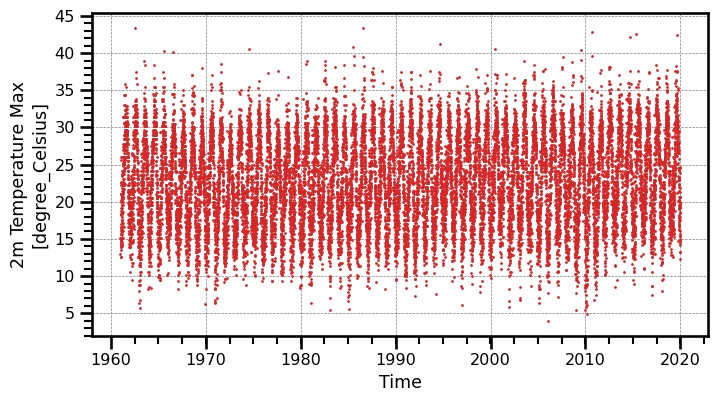

In [9]:
fig, ax, pts = plot_scatter_ts(ds_station[variable_name], x_variable="time", markersize=1.0)

ax.set(
    xlabel="Time"
)
fig.set(
    dpi=100,
    size_inches=(7,4)
)
plt.show()

### Viz - Density

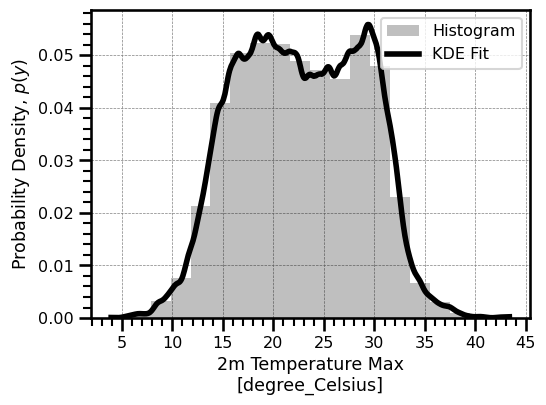

In [10]:
fig, ax = plot_density(ds_station[variable_name])

fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.show()

## Blocks II - Years

In this first attempt, we will do the quantiles of all of the data, irrespective of the *cycles*.

In [11]:
da = ds_station[variable_name]

da

<xarray.DataArray 't2m_max' (time: 21549)> Size: 86kB
array([13.032125, 15.1     , 18.2     , ..., 15.4     , 16.      ,
       15.4     ], dtype=float32)
Coordinates:
    alt             float32 4B 56.0
    lat             float32 4B 39.48
    lon             float32 4B -0.476
    red_feten_mask  uint8 1B 1
    station_id      <U5 20B '8414A'
    station_name    <U50 200B 'valencia, aeropuerto'
  * time            (time) datetime64[ns] 172kB 1961-01-01 ... 2019-12-31
Attributes:
    long_name:      2m Temperature Max
    standard_name:  2m_temperature_max
    units:          degree_Celsius

In [12]:
from st_evt.extremes import block_maxima_year, block_maxima_yearly_group


ds_station["bm_year"] = block_maxima_year(ds_station[variable_name])
ds_station.bm_year

<xarray.DataArray 'bm_year' (time: 21549)> Size: 86kB
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    alt             float32 4B 56.0
    lat             float32 4B 39.48
    lon             float32 4B -0.476
    red_feten_mask  uint8 1B 1
    station_id      <U5 20B '8414A'
    station_name    <U50 200B 'valencia, aeropuerto'
  * time            (time) datetime64[ns] 172kB 1961-01-01 ... 2019-12-31
Attributes:
    long_name:      2m Temperature Max
    standard_name:  2m_temperature_max
    units:          degree_Celsius

### Viz - Time Series

Now, let's visualize the maximum values we have obtained on top of the 

In [13]:


from typing import Optional

def plot_ts_scatter_station_bm(ds_station, ds_pot):

    fig, ax = plt.subplots(figsize=(10,5))
    ds_pot.plot.scatter(x="time", ax=ax, color="tab:red", s=30.0, zorder=3, label="Block Maxima Values")
    ds_station.plot.scatter(x="time", ax=ax, color="tab:blue", s=5.0, zorder=1, label="Data")
    ax.set(
        xlabel="Time",
        title=""
    )
    ax.xaxis_date()
    ax.grid(True, linestyle='--', linewidth='0.5', color='gray')
    ax.minorticks_on()
    plt.legend(fontsize=12)
    plt.tight_layout()
    return fig, ax

/tmp/ipykernel_1057503/1458763101.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


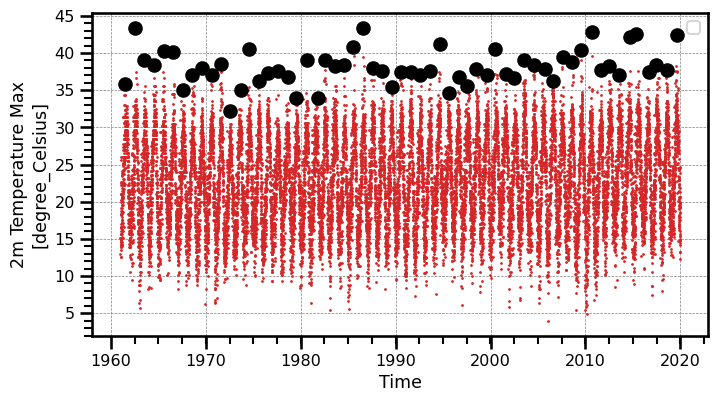

In [14]:
fig, ax, pts = plot_scatter_ts(
    ds_station[variable_name],
    markersize=1.0
)
ds_station["bm_year"].plot.scatter(x="time", ax=ax, color="black", zorder=3)
ax.set(
    xlabel="Time",
    title=""
)

fig.set_dpi(100)
plt.legend()
plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(7,4)
)
plt.show()

### Viz - Scatter

/tmp/ipykernel_1057503/3297811031.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


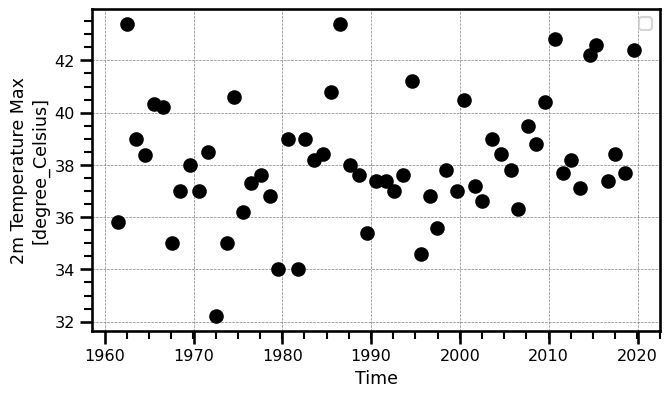

In [15]:
fig, ax = plt.subplots()
ds_station["bm_year"].plot.scatter(x="time", ax=ax, color="black", zorder=3)

ax.set(
    title="",
    xlabel="Time"
)
ax.xaxis_date()
ax.grid(True, linestyle='--', linewidth='0.5', color='gray')
ax.minorticks_on()
plt.legend()
plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(7,4)
)
plt.show()

We see that there are a lot less observations. 
However, there does appear to be a trend in the mean/median of the data.
The first few decades has a large spread whereas the later decades appear to have a smaller spread.

**Warning**.
We must be careful because we have significantly less amount of data.
This limits our ability to make any grandiose conclusions.
However, at the very least, we can try to model the trend.

Below, we have a figure showing what a single year looks like and the maximum value that we use.

### Viz - Single Year

In [16]:
from typing import Optional

def plot_ts_line_station_bm(ds_station, ds_pot, figures_save_dir: Optional[str]=None):

    fig, ax = plt.subplots(figsize=(10,5))
    ds_pot.plot.scatter(x="time",  ax=ax, color="tab:red", s=30.0, zorder=3)
    ds_station.plot.line(ax=ax, x="time", color="tab:blue", zorder=1, linewidth=2.0)
    ax.set(
        xlabel="Time",
        title="",
    )
    ax.xaxis_date()
    ax.grid(True, linestyle='--', linewidth='0.5', color='gray')
    ax.minorticks_on()
    plt.tight_layout()
    return fig, ax

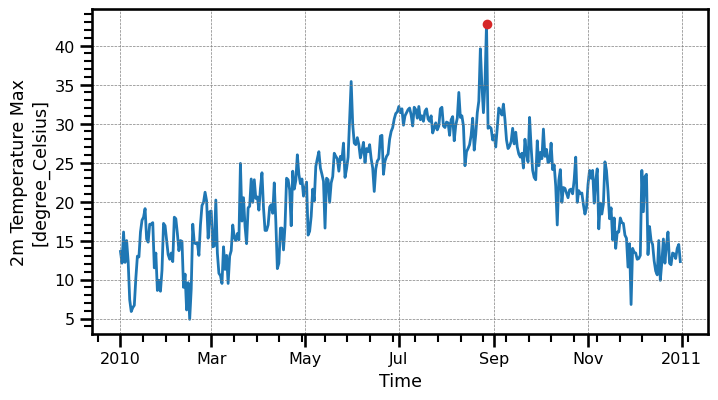

In [19]:
fig, ax = plot_ts_line_station_bm(
    ds_station[variable_name].sel(time=slice("2010", "2010")),
    ds_station["bm_year"].sel(time=slice("2010", "2010")),
    None
)
fig.set(
    dpi=100,
    size_inches=(7,4)
)
plt.show()

Above, we have a figure of the year 2010.
We see that there is a **single maximum value** that we obtain per year.

### Viz - Histogram

Now, we can take a peek at the density plot to see what the distribution looks like.
In theory, it should be different than the original distibution with the daily blocked values.

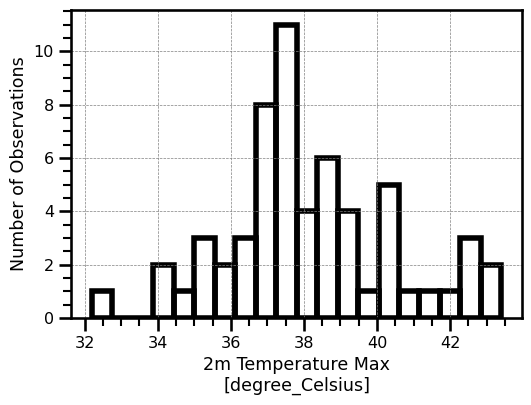

In [20]:
fig, ax = plot_histogram(ds_station["bm_year"])
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.show()

We make two observations right away.

**Number of Observations**.
The first thing we notice is that the number of observations becomes very small.
This makes sense as we are only taking the number of observations as years.

**Distribution Shape**.
The second thing we notice is that the distribution shape looks a lot like some of the *extreme value theory* (EVT).
This is a good thing because it means that we can start thinking about how we can potentially *model* this data using a probability distribution.
It helps to have an idea about which distribution makes more sense but a first pass is always to plot the data and then compare it to previously known distributions.


We can (of course) plot the PDF using our trust-worthy non-parametric density estimator.


### Viz - Density

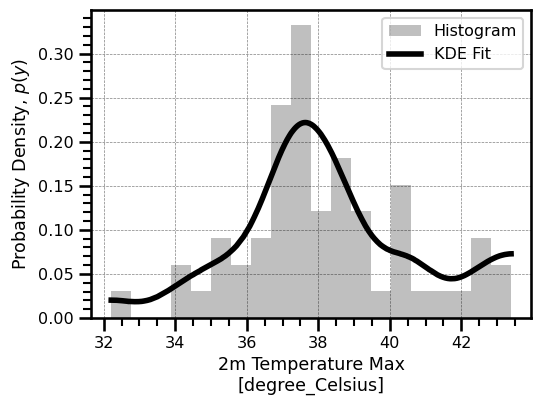

In [21]:
fig, ax = plot_density(ds_station["bm_year"])

fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.show()


Most people won't recognized this distribution from the standard ones that they teach us in class.
However, this corresponds to the some of classical GEVD found [here](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution).

In [22]:
# return_period_size = pd.to_timedelta("365.2423D")
# n_periods = (ds_station.time.max().values - ds_station.time.min().values) / return_period_size
# print(f"Number of Periods: {n_periods}")

# extremes_rate = np.sum(~np.isnan(ds_station["pot_q095"].values)) / n_periods
# print(f"Extremes Rate: {extremes_rate}")

## Block II - Seasons

As shown in a previous tutorial, *cycles* tend to cause problems for time series.
Again, this is because there is some behaviour that is present in one part of the cycle whereas another behaviour is present in another part of the cycle.
In natural data, one of the most prominent cycles is the seasonal cycle whereby many behaviours are repeated on a seasonal level.
So, a simple way to deal with this in our data would be to chunk up our data on a seasonal level.


```{figure} https://www.shutterstock.com/image-vector/vector-set-illustration-4-seasons-260nw-1634511454.jpg
:label: seasonal_cycle_crude
:alt: Sunset at the beach
:align: center

A crude seasonal cycle. Source: [shutterstock](https://www.shutterstock.com/image-vector/autumn-winter-spring-summer-tree-collection-2367889321).
```


In [23]:
group = "time.season"
ds_station["bm_season"] = block_maxima_yearly_group(ds_station[variable_name].transpose("time"), group)
ds_station.bm_season

<xarray.DataArray 'bm_season' (time: 21549)> Size: 86kB
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    alt             float32 4B 56.0
    lat             float32 4B 39.48
    lon             float32 4B -0.476
    red_feten_mask  uint8 1B 1
    station_id      <U5 20B '8414A'
    station_name    <U50 200B 'valencia, aeropuerto'
  * time            (time) datetime64[ns] 172kB 1961-01-01 ... 2019-12-31
Attributes:
    long_name:      2m Temperature Max
    standard_name:  2m_temperature_max
    units:          degree_Celsius

### Viz - Time Series

/tmp/ipykernel_1057503/2985799534.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


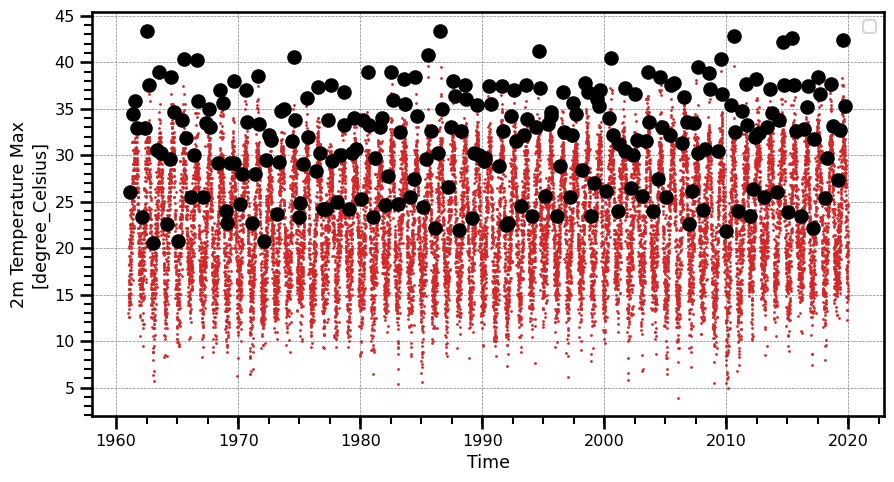

In [24]:
fig, ax, pts = plot_scatter_ts(
    ds_station[variable_name],
    markersize=1.0
)
ds_station["bm_season"].plot.scatter(x="time", ax=ax, color="black", zorder=3)
ax.set(
    xlabel="Time",
    title=""
)

fig.set_dpi(100)
plt.legend()
plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(9,5)
)
plt.show()

/tmp/ipykernel_1057503/4110526127.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


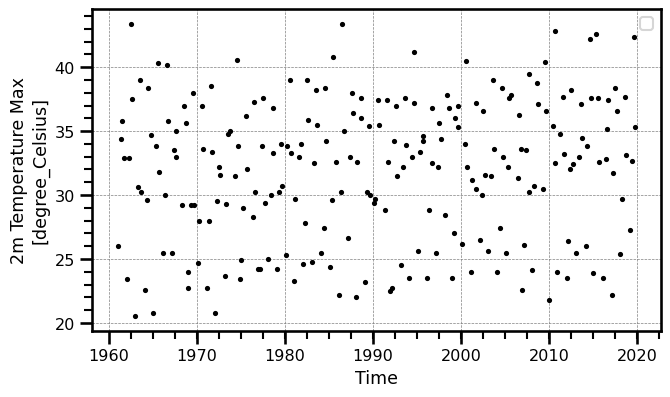

In [25]:
fig, ax = plt.subplots()
ds_station["bm_season"].plot.scatter(x="time", ax=ax, color="black", s=5.0, zorder=3)

ax.set(
    title="",
    xlabel="Time"
)
ax.xaxis_date()
ax.grid(True, linestyle='--', linewidth='0.5', color='gray')
ax.minorticks_on()
plt.legend()
plt.tight_layout()
fig.set(
    dpi=100,
    size_inches=(7,4)
)
plt.show()

### Viz - Single Year

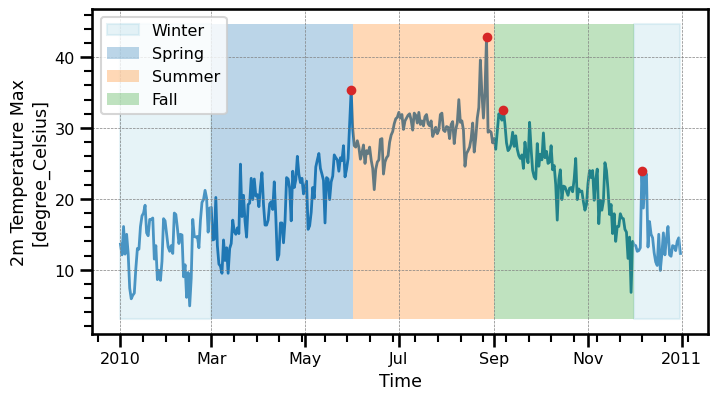

In [26]:
example_year = "2010"
fig, ax = plot_ts_line_station_bm(
    ds_station[variable_name].sel(time=slice(example_year, example_year)),
    ds_station["bm_season"].sel(time=slice(example_year, example_year)),
)

seasons = {
        'Winter': (f'{example_year}-12-01', f'{example_year}-03-01'),
    'Spring': (f'{example_year}-03-01', f'{example_year}-06-01'),
    'Summer': (f'{example_year}-06-01', f'{example_year}-09-01'),
    'Fall': (f'{example_year}-09-01', f'{example_year}-12-01')
}
# Add shaded regions for each season
ylim = ax.get_ylim()
for season, (start, end) in seasons.items():
    t0 = pd.to_datetime(start)
    t1 = pd.to_datetime(end)
    if season == 'Winter':
        
        t_end = pd.to_datetime(f'{example_year}-12-31')
        t_begin = pd.to_datetime(f'{example_year}-01-01')
        
        # Winter spans the end of the year to the beginning of the next year
        ax.fill_betweenx(ylim, t0, t_end, color='lightblue', alpha=0.3, label=season)
        ax.fill_betweenx(ylim, t_begin, t1, color='lightblue', alpha=0.3)
    else:
        ax.fill_betweenx(ylim, t0, t1, alpha=0.3, label=season)
plt.tight_layout()
plt.legend()
fig.set(
    dpi=100,
    size_inches=(7,4)
)
plt.show()

We see that we have a few maximums depending upon the season.

### Viz - Histogram

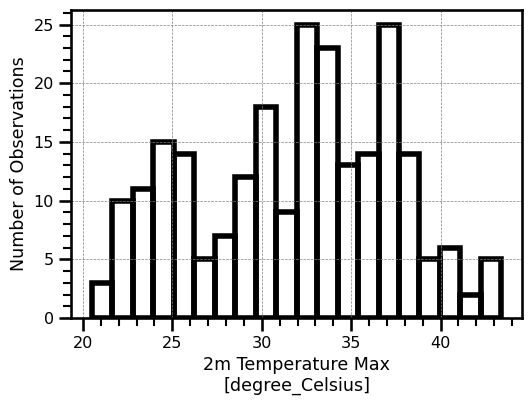

In [28]:
fig, ax = plot_histogram(ds_station["bm_season"])
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.show()

### Viz - Density

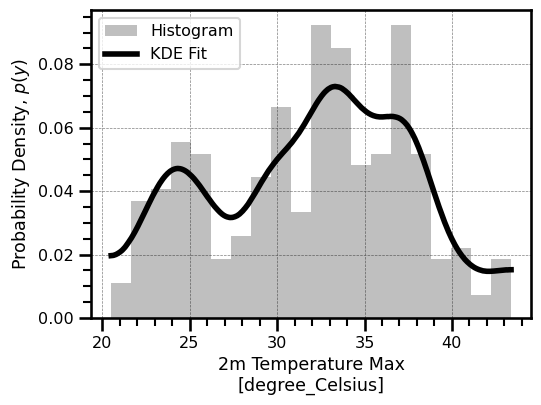

In [29]:
fig, ax = plot_density(ds_station["bm_season"])
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.show()


We notice right away that the distribution is quite different than the previous yearly maximum values.
This makes sense because we have purposefully introduced groups into our dataset by taking the maximum values of seasons.
So, naturally, this results in different distributions per seasons which move in a cyclic manner.

In the next section, we will visualize what each blocks look like.

### Viz - Seasonal Blocks - Scatter

In [30]:
# fig, axes = plt.subplots(ncols=2, nrows=2, tight_layout=True, figsize=(15, 10))
# for iax, (i, ida) in zip(axes.ravel(), list(ds_station["bm_season"].groupby("time.season"))):
#     _, _, _ = plot_scatter_station(
#         ida,
#         ax=iax,
#     )
#     iax.set(title=f"Season: {i}")
# plt.show()

### Viz - Seasonal Blocks - Densities

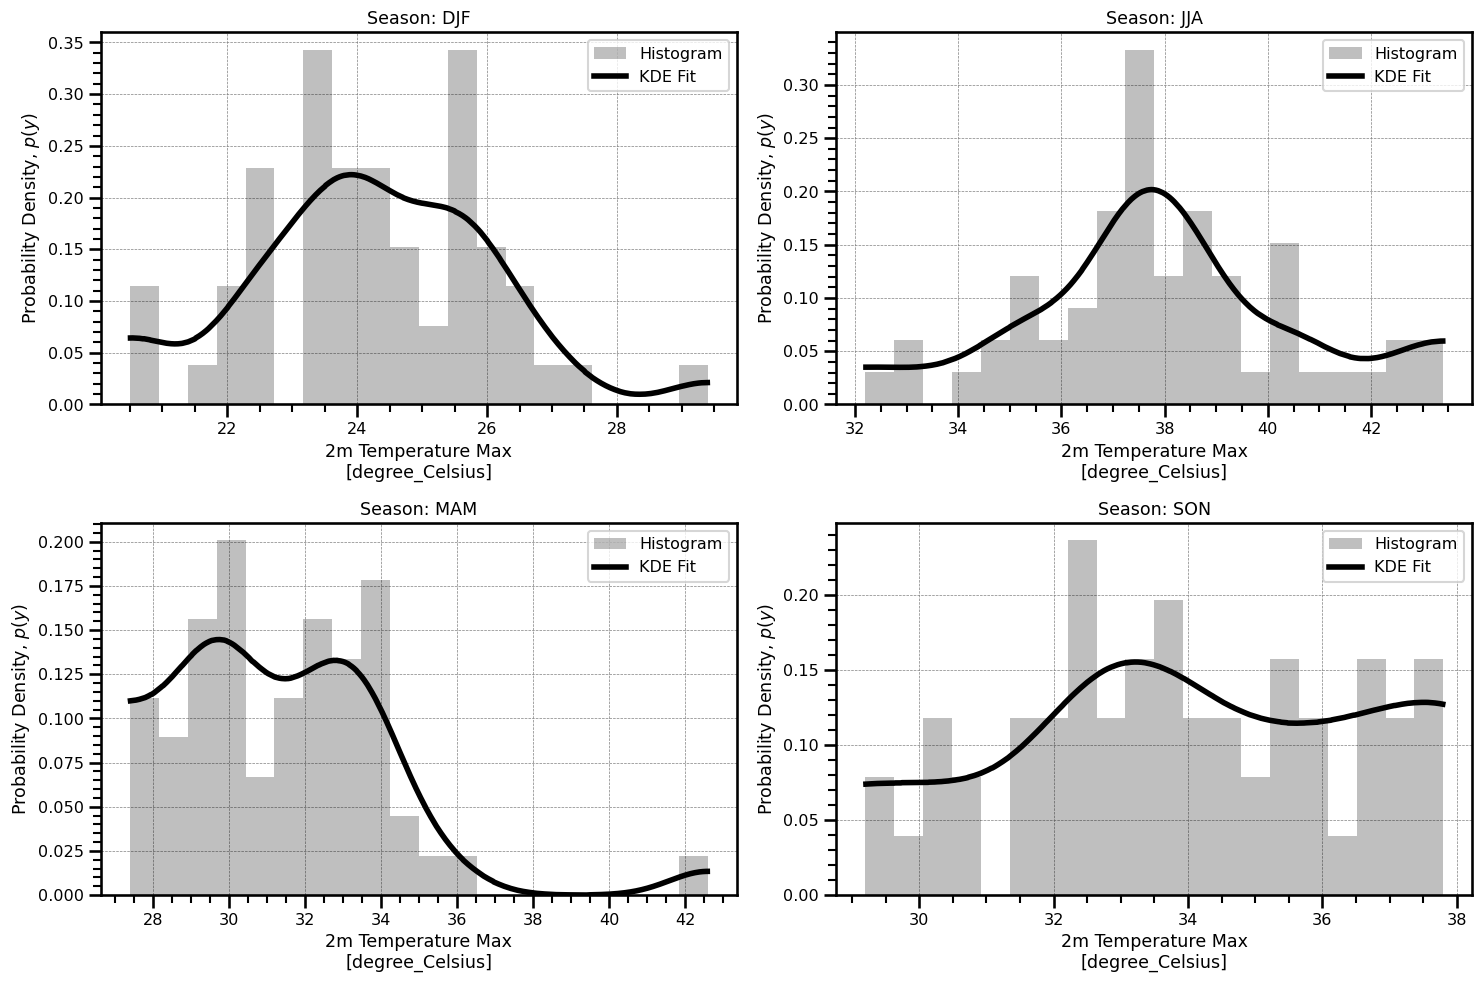

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=2, tight_layout=True, figsize=(15, 10))
for iax, (i, ida) in zip(axes.ravel(), list(ds_station["bm_season"].groupby("time.season"))):
    _, _ = plot_density(
        ida,
        ax=iax,
    )
    iax.set(title=f"Season: {i}")
fig.set(
    dpi=100,
    # size_inches=(7,4)
)
plt.show()


## Block III - Months

In this first attempt, we will do the quantiles of the data keeping in mind the cycles that may be present.
So in this case, we know

In [35]:
group = "time.month"
ds_station["bm_month"] = block_maxima_yearly_group(ds_station[variable_name], group)

In [36]:
# block_size = "30.5D"
# ds_station[f"bm_month"] = estimate_bm_extremes_mask(
#     ds_station.t2m_max,
#     block_size=block_size,
# )
# ds_station

### Viz - Histogram

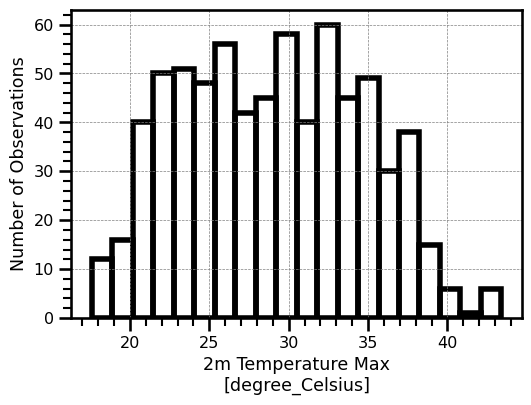

In [39]:
fig, ax = plot_histogram(ds_station["bm_month"])
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.show()

### Viz - Density Plot

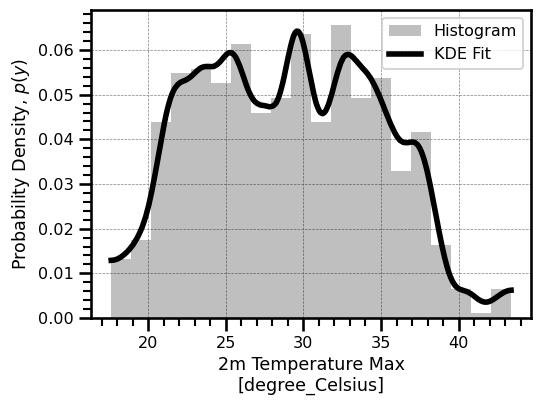

In [40]:
fig, ax = plot_density(ds_station["bm_month"])
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.show()


### Viz - Time Series + BMs

In [41]:
# fig, ax = plot_ts_scatter_station_bm(
#     ds_station[variable_name],
#     ds_station["bm_month"],
# )
# plt.show()

In [42]:
# fig, ax, pts = plot_scatter_station(
#     ds_station["bm_month"],
# )
# plt.show()

### Viz - Shaded Blocks - Time Series

In [43]:
# example_year = 2010
# fig, ax = plot_ts_line_station_bm(
#     ds_station[variable_name].sel(time=slice(str(example_year), str(example_year))),
#     ds_station["bm_month"].sel(time=slice(str(example_year), str(example_year))),
# )

# months = {
#     'January': (f'{example_year}-01-01', f'{example_year}-02-01'),
#     'February': (f'{example_year}-02-01', f'{example_year}-03-01'),
#     'March': (f'{example_year}-03-01', f'{example_year}-04-01'),
#     'April': (f'{example_year}-04-01', f'{example_year}-05-01'),
#     'May': (f'{example_year}-05-01', f'{example_year}-06-01'),
#     'June': (f'{example_year}-06-01', f'{example_year}-07-01'),
#     'July': (f'{example_year}-07-01', f'{example_year}-08-01'),
#     'August': (f'{example_year}-08-01', f'{example_year}-09-01'),
#     'September': (f'{example_year}-09-01', f'{example_year}-10-01'),
#     'October': (f'{example_year}-10-01', f'{example_year}-11-01'),
#     'November': (f'{example_year}-11-01', f'{example_year}-12-01'),
#     'December': (f'{example_year}-12-01', f'{example_year + 1}-01-01')
# }
# # Define the boundaries and colors for the periodic colorbar
# colors = plt.cm.RdBu(np.linspace(0, 1, 12))
# colors = np.concatenate([colors[-5:], colors[:-5]], axis=0)

# # Add shaded regions for each season
# ylim = ax.get_ylim()
# for i, (month, (start, end)) in enumerate(months.items()):
#     t0 = pd.to_datetime(start)
#     t1 = pd.to_datetime(end)
#     ax.fill_betweenx(ylim, t0, t1, alpha=0.3, label=month, color=colors[i])
# plt.tight_layout()
# ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.show()

### Viz - Shaded Time Series - Scatter

In [44]:
# fig, ax = plot_ts_scatter_station_bm(
#     ds_station[variable_name].sel(time=slice(str(example_year), str(example_year))),
#     ds_station["bm_month"].sel(time=slice(str(example_year), str(example_year))),
# )

# # Define the boundaries and colors for the periodic colorbar
# colors = plt.cm.RdBu(np.linspace(0, 1, 12))
# colors = np.concatenate([colors[-5:], colors[:-5]], axis=0)

# # Add shaded regions for each season
# ylim = ax.get_ylim()
# for i, (month, (start, end)) in enumerate(months.items()):
#     t0 = pd.to_datetime(start)
#     t1 = pd.to_datetime(end)
#     ax.fill_betweenx(ylim, t0, t1, alpha=0.3, label=month, color=colors[i])
# plt.tight_layout()
# ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.show()

### Viz - Monthly Blocks - Scatter

In [45]:
# fig, axes = plt.subplots(ncols=3, nrows=4, tight_layout=True, figsize=(20, 15))
# for iax, (i, ida) in zip(axes.ravel(), list(ds_station["bm_month"].groupby("time.month"))):
#     _, _, _ = plot_scatter_station(
#         ida,
#         ax=iax,
#     )
#     iax.set(title=f"Month: {i}")
# plt.show()


### Viz - Monthly Blocks - Densities

In [46]:
# fig, axes = plt.subplots(ncols=3, nrows=4, tight_layout=True, figsize=(20, 15))
# for iax, (i, ida) in zip(axes.ravel(), list(ds_station["bm_month"].groupby("time.month"))):
#     _, _ = plot_density_station(
#         ida,
#         ax=iax,
#     )
#     iax.set(title=f"Month: {i}")
# plt.show()
